In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-01-08 16:43:56--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-01-08 16:43:56 (85.7 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



#**Callbacks**

In [2]:
def tensorboard_callback(log_dir):
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print("saving tensorboard logs to:", log_dir)
  return tensorboard_callback

In [3]:
def early_stop():
  early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3)
  return early_stop

In [4]:
def reduce_lr():
  reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)
  return reduce_lr

#**Getting and analyzing data**

In [5]:
import zipfile
zip_ref=zipfile.ZipFile("nlp_getting_started.zip")
zip_ref.extractall()
zip_ref.close()

In [6]:
import pandas as pd

In [7]:
train_df=pd.read_csv("train.csv")
train_df=train_df.sample(frac=1) #shuffle data
test_df=pd.read_csv("test.csv")
test_df=test_df.sample(frac=1) #shuffle data

In [8]:
print("len train:",len(train_df))
print("len test:",len(test_df))

len train: 7613
len test: 3263


In [9]:
train_df.head()

,id,keyword,location,text,target
3557,5083,famine,Massachusetts,Russia destroys food while people go hungry. ...,1
3152,4526,emergency,Adelaide,Myanmar floods: Childfund https://t.co/pQHQ4Jn...,1
3047,4374,earthquake,New Zealand,GNS sees unnecessary deaths resulting from ear...,1
1058,1527,body%20bags,NaN,Mens Cross Body Canvas Waist Packs Solid Lette...,0
3184,4571,emergency%20plan,Calgary,Hello Calgary!! Important news!! Please be adv...,1


In [10]:
train_df["target"].value_counts() #0 for no disaster, 1 for disaster

0    4342
1    3271
Name: target, dtype: int64

In [11]:
test_df.head()

,id,keyword,location,text
1618,5447,first%20responders,NaN,Allergan Kicks off REFRESH AMERICA Program to ...
1858,6266,hijacking,Maryland,But is feast.dll still vulnerable to DLL hijac...
2620,8765,siren,New York,WHELEN MODEL 295SS-100 SIREN AMPLIFIER POLICE ...
1510,5026,eyewitness,NaN,@EdmundAdamus @CampionJoanne Pres Carter's not...
3209,10653,wounds,Vancouver,@WorldRunners @RunningRoom Day 3&amp;my wounds...


In [12]:
import random
random_index=random.randint(0,len(train_df)-5)
for row in train_df[random_index: random_index+5].itertuples():
  _,_,_,_,text,label=row
  print(f"target_label:{label}\ntext:\n{text}\n---\n")

target_label:0
text:
'Motordom' lobbied to change our language around traffic fatalities. We need to go back to the future #VisionZero  https://t.co/cAvb7pgEpv
---

target_label:1
text:
Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/h6Z7hXUqtu via @YahooNews
---

target_label:1
text:
Suicide bombing is just the fear of dying alone
---

target_label:1
text:
70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/vFCtrzaOk2
---

target_label:0
text:
'My Fifty Online Dates and why I'm still single' by Michael Windstorm $2.99 Amazon http://t.co/5KohO39oJE    #kindle  #datingtips #goodreads
---



**Creating validation data**: since the test data does not contain labels. 

In [13]:
from sklearn.model_selection import train_test_split

train_text, validation_text, train_labels, validation_labels= train_test_split(train_df["text"].to_numpy(), train_df["target"].to_numpy(), test_size=0.1)

In [14]:
print(len(train_text), len(validation_text))

6851 762


In [15]:
train_text[:5], train_labels[:5]

(array(["Feel like I've got no control of anything that goes on in my life at the minute. #whirlwind #drained",
        'People donå«t want to hear the truth because they donå«t want  their illusions destroyed. #FN.',
        "Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/M4TcZaawpT",
        '@Bill_Roose That looks so desolate and just...depressing',
        '@WillHillBet what is double result live on the app?'],
       dtype=object), array([1, 0, 0, 1, 0]))

In [16]:
import tensorflow as tf
tf.__version__

'2.9.2'

#**Tokenization**: converting text to numbers

In [17]:
text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=None, #vocabulary
                                                  standardize="lower_and_strip_punctuation",
                                                  split="whitespace",
                                                  ngrams=None, #group of n-words as tokens
                                                  output_mode="int", #how to map tokens to numbers
                                                  output_sequence_length=None) #len of output sequence of tokens

In [18]:
train_text[0].split()

['Feel',
 'like',
 "I've",
 'got',
 'no',
 'control',
 'of',
 'anything',
 'that',
 'goes',
 'on',
 'in',
 'my',
 'life',
 'at',
 'the',
 'minute.',
 '#whirlwind',
 '#drained']

In [19]:
round(sum([len(i.split()) for i in train_text])/len(train_text))

15

In [20]:
max_vocab_len=10000 #the 10000 most frequent words will serve as the vocab and the rest will be made into OOV (out of vocab)
max_length=15 #ie the avg number of tokens per sample

text_vectorizer=tf.keras.layers.TextVectorization(max_tokens=max_vocab_len,
                                                  output_sequence_length=max_length)

In [21]:
text_vectorizer.adapt(train_text)

In [22]:
sample="hi, my name is jothish" #1 in output vector represents oov
text_vectorizer([sample])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1661,   13,  802,    9,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [23]:
random_sentence=random.choice(train_text)
vectorized_sentence=text_vectorizer([random_sentence])
print(f"random text:\n{random_sentence}\n\nvectorised text:\n{vectorized_sentence}")

random text:
@Allahsfinest12 ...death to muslims

vectorised text:
[[  1 151   5 939   0   0   0   0   0   0   0   0   0   0   0]]


In [24]:
vocab=text_vectorizer.get_vocabulary()
print("vocab learnt: ",len(vocab))
print("most common words: ",vocab[:5])
print("least common words: ",vocab[-5:])

vocab learnt:  10000
most common words:  ['', '[UNK]', 'the', 'a', 'in']
least common words:  ['pacic', 'pa', 'p45perez', 'p2', 'oyster']


#**Embedding**: A matrix to better understand the use case of the  word.(can be learned)

In [25]:
embedding_layer_1=tf.keras.layers.Embedding(input_dim=max_vocab_len,
                                          output_dim=128, #The dimensions to learn the usage of the word, the more the better
                                          input_length=max_length)

In [26]:
embedded_sentence=embedding_layer_1(text_vectorizer([random_sentence]))
embedded_sentence

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00665051, -0.01389895, -0.04567504, ..., -0.04051869,
         -0.00276364, -0.00252954],
        [ 0.03155181, -0.01944989, -0.00462038, ...,  0.0240537 ,
          0.01856183,  0.01640794],
        [ 0.03607235, -0.03889413,  0.03777992, ...,  0.02867213,
          0.01735068, -0.04764024],
        ...,
        [-0.04839122,  0.02620942, -0.01466624, ...,  0.02090702,
          0.01447942, -0.01160545],
        [-0.04839122,  0.02620942, -0.01466624, ...,  0.02090702,
          0.01447942, -0.01160545],
        [-0.04839122,  0.02620942, -0.01466624, ...,  0.02090702,
          0.01447942, -0.01160545]]], dtype=float32)>

In [27]:
print("The sentence:\n",random_sentence,"\n\n")
print(f"The word: {random_sentence.split()[0]} \n\nIs represented by:\n{embedded_sentence[0][0]}")

The sentence:
 @Allahsfinest12 ...death to muslims 


The word: @Allahsfinest12 

Is represented by:
[-6.6505075e-03 -1.3898946e-02 -4.5675039e-02  4.3831993e-02
 -1.8837666e-02  1.5852299e-02 -3.4194469e-02 -1.3940144e-02
  1.4553595e-02  1.2139000e-02  1.1954784e-02  4.1938554e-02
 -1.7572045e-02  1.4314834e-02 -1.0239936e-02 -6.3441694e-05
  7.0921667e-03 -3.8750850e-02  1.6626764e-02 -2.1675408e-02
  3.2754470e-02 -3.3242751e-02 -1.0170292e-02  2.5990818e-02
  9.8136812e-04  8.6452141e-03  1.4716040e-02 -4.0333785e-02
  3.6433209e-02  3.6132935e-02 -2.4853682e-02 -1.2182057e-02
 -3.6489092e-02 -8.8964477e-03 -8.0305934e-03 -1.1230506e-02
 -3.2580853e-02 -3.9711259e-02 -6.7969784e-03 -3.0671228e-02
 -2.9217117e-03 -7.7002868e-03  2.1448079e-02 -5.5157430e-03
 -3.6711656e-02  9.2396140e-03  1.2588110e-02 -3.3587471e-02
 -2.9325867e-02 -4.3941882e-02 -2.4926519e-02  2.9330477e-03
 -4.4631064e-02  6.1375871e-03 -5.2500591e-03  4.9573276e-02
 -5.6454651e-03  1.1678506e-02 -4.3850910e-02

#**Model_0**: Naive Bais_sklearn

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tfidf", TfidfVectorizer()),
                  ("clf", MultinomialNB())])

model_0.fit(train_text, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
model_0_accuracy=model_0.score(validation_text, validation_labels)
print("Model_0 accuracy: %.2f" %model_0_accuracy)

Model_0 accuracy: 0.81


In [30]:
random_sentence

'@Allahsfinest12 ...death to muslims'

In [31]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([random_sentence])

In [32]:
print(X)

  (0, 2)	0.5
  (0, 3)	0.5
  (0, 1)	0.5
  (0, 0)	0.5


**Model evaluation function**

In [33]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def calculate_metrics(y_true, y_preds):
  model_results={"Accuracy": accuracy_score(y_true, y_preds),
                 "Precision": precision_score(y_true, y_preds),
                 "Recall": recall_score(y_true, y_preds),
                 "f1_score": f1_score(y_true, y_preds),
                 }
  return model_results


In [34]:
model_0_results=calculate_metrics(validation_labels, model_0.predict(validation_text))

In [35]:
model_0_results

{'Accuracy': 0.8149606299212598,
 'Precision': 0.8835341365461847,
 'Recall': 0.6626506024096386,
 'f1_score': 0.757314974182444}

#**Modle_1**: Feed forward neural network

In [36]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding_layer_1(x)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_1= tf.keras.Model(inputs, outputs)

In [37]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

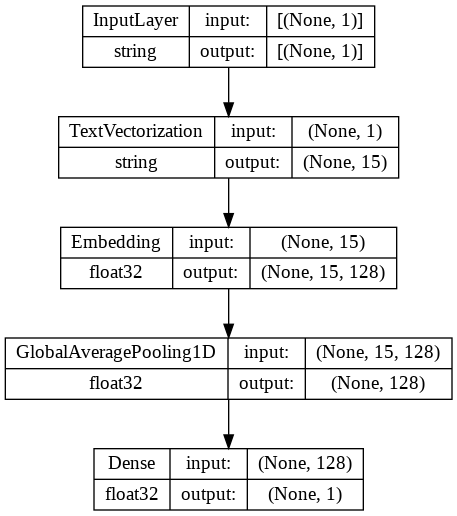

In [38]:
tf.keras.utils.plot_model(model_1, show_shapes=True, show_dtype=True, show_layer_names=False)

In [39]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_1=model_1.fit(train_text,train_labels,
                      epochs=25,
                      validation_data=(validation_text, validation_labels),
                      callbacks=[reduce_lr(), early_stop(), tensorboard_callback("tensorboard/model_1_FeedForwardNN")]
                      )

saving tensorboard logs to: tensorboard/model_1_FeedForwardNN
Epoch 1/25
215/215 [==============================] - 8s 31ms/step - loss: 0.6115 - accuracy: 0.6946 - val_loss: 0.5205 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 2/25
215/215 [==============================] - 6s 28ms/step - loss: 0.4455 - accuracy: 0.8146 - val_loss: 0.4375 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 3/25
215/215 [==============================] - 6s 28ms/step - loss: 0.3505 - accuracy: 0.8610 - val_loss: 0.4209 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/25
215/215 [==============================] - 6s 29ms/step - loss: 0.2876 - accuracy: 0.8885 - val_loss: 0.4269 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 5/25
214/215 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9084
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
215/215 [==============================] - 5s 25ms/step - loss: 0.2392 - accuracy: 0.9085 - val_loss: 0.4455 - val_accuracy: 0.8163 - lr: 0.0

In [40]:
y_preds=tf.squeeze(tf.round(model_1.predict(validation_text)))

24/24 [==============================] - 0s 3ms/step


In [41]:
y_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1

In [42]:
model_1_results=calculate_metrics(validation_labels, y_preds)

In [43]:
model_1_results

{'Accuracy': 0.8188976377952756,
 'Precision': 0.8069620253164557,
 'Recall': 0.7680722891566265,
 'f1_score': 0.7870370370370369}

In [44]:
embed_layer_weights=model_1.get_layer("embedding").get_weights()[0]

In [45]:
embed_layer_weights, embed_layer_weights.shape

(array([[-6.6351548e-02,  8.4692677e-03, -3.2497313e-02, ...,
          4.3021915e-03,  3.2644745e-02,  8.6700747e-06],
        [-1.3542930e-02, -2.0644173e-02, -5.2546851e-02, ...,
         -4.6979867e-02,  4.2242394e-03,  3.9558529e-04],
        [-3.9668016e-02, -2.4870392e-02, -4.4159383e-02, ...,
         -1.7253229e-02, -2.1264438e-02,  2.2582721e-02],
        ...,
        [-1.1743251e-02, -6.0459353e-02, -5.1776577e-02, ...,
         -3.7353621e-03,  3.7719652e-02,  4.5462947e-02],
        [-7.1160756e-02, -6.9683775e-02, -1.0040428e-01, ...,
         -5.8094513e-02,  6.1143555e-02,  5.0807580e-02],
        [-5.0167277e-02, -2.3314625e-02, -1.0532673e-01, ...,
         -9.9164292e-02,  9.2136703e-02,  1.4426387e-02]], dtype=float32),
 (10000, 128))

#**Visualising embeddings**

In [46]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_layer_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

#**Model_2**: RNN(LSTM)

In [48]:
embedding_layer_2=tf.keras.layers.Embedding(input_dim= max_vocab_len,
                                            output_dim=128,
                                            input_length= max_length)

In [49]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding_layer_2(x)
#x=tf.keras.layers.LSTM(64, return_sequences=True)(x)
x=tf.keras.layers.LSTM(64)(x)
#x=tf.keras.layers.Dense(16, activation="relu")(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2=tf.keras.Model(inputs, outputs)

In [50]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [51]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2=model_2.fit(train_text, train_labels,
                      epochs=5,
                      validation_data=(validation_text, validation_labels),
                      callbacks=[tensorboard_callback("tensorboard/model_2_LSTM")],
                      )

saving tensorboard logs to: tensorboard/model_2_LSTM
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5150 - accuracy: 0.7466 - val_loss: 0.4485 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3243 - accuracy: 0.8648 - val_loss: 0.4393 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.2246 - accuracy: 0.9142 - val_loss: 0.5286 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1540 - accuracy: 0.9438 - val_loss: 0.6666 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1101 - accuracy: 0.9555 - val_loss: 1.0961 - val_accuracy: 0.7441


In [52]:
y_preds=tf.squeeze(model_2.predict(validation_text).round())

24/24 [==============================] - 1s 5ms/step


In [53]:
model_2_results=calculate_metrics(validation_labels, y_preds)

In [54]:
model_2_results

{'Accuracy': 0.7440944881889764,
 'Precision': 0.6951566951566952,
 'Recall': 0.7349397590361446,
 'f1_score': 0.7144948755490483}

#**Model_3**: RNN(GRU)
>GRUs have lesser number of parameters than an LSTM

In [55]:
embedding_layer_3=tf.keras.layers.Embedding(input_dim=max_vocab_len,
                                            output_dim=128,
                                            input_length=max_length)

In [56]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding_layer_3(x)
x=tf.keras.layers.GRU(64)(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_3=tf.keras.Model(inputs, outputs)

In [57]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [58]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3= model_3.fit(train_text, train_labels,
                       epochs=5,
                       validation_data=(validation_text, validation_labels),
                       callbacks=[tensorboard_callback("tensorboard/model_3_GRU")])

saving tensorboard logs to: tensorboard/model_3_GRU
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.5246 - accuracy: 0.7329 - val_loss: 0.4079 - val_accuracy: 0.8215
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3222 - accuracy: 0.8657 - val_loss: 0.4278 - val_accuracy: 0.8176
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2185 - accuracy: 0.9181 - val_loss: 0.5026 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1567 - accuracy: 0.9453 - val_loss: 0.6446 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1176 - accuracy: 0.9618 - val_loss: 0.6121 - val_accuracy: 0.7887


In [59]:
y_preds=tf.squeeze(model_3.predict(validation_text).round())

24/24 [==============================] - 1s 4ms/step


In [60]:
model_3_results=calculate_metrics(validation_labels, y_preds)

In [61]:
model_3_results

{'Accuracy': 0.7887139107611548,
 'Precision': 0.8042704626334519,
 'Recall': 0.6807228915662651,
 'f1_score': 0.737357259380098}

#**Model_4**: RNN(Bidirectional)
>Bidirectional acts as a wrapper and wraps over any RNN. Intutively it enables representation of a sentence in both directions.

1)left to right(usual scope of RNN)

2)right to left

In [62]:
embedding_layer_4=tf.keras.layers.Embedding(input_dim= max_vocab_len,
                                            output_dim= 128,
                                            input_length= max_length)

In [63]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding_layer_4(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_4=tf.keras.Model(inputs, outputs)

In [64]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [65]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4=model_4.fit(train_text, train_labels,
                      epochs=5,
                      validation_data=(validation_text, validation_labels),
                      callbacks=[tensorboard_callback("tensorboard/model_4_bidirectional_LSTM")])

saving tensorboard logs to: tensorboard/model_4_bidirectional_LSTM
Epoch 1/5
215/215 [==============================] - 15s 43ms/step - loss: 0.5124 - accuracy: 0.7473 - val_loss: 0.4316 - val_accuracy: 0.8241
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3149 - accuracy: 0.8676 - val_loss: 0.4865 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2117 - accuracy: 0.9215 - val_loss: 0.5424 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1437 - accuracy: 0.9499 - val_loss: 0.6321 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1001 - accuracy: 0.9632 - val_loss: 0.7858 - val_accuracy: 0.7756


In [66]:
y_preds=tf.squeeze(model_4.predict(validation_text).round())

24/24 [==============================] - 1s 8ms/step


In [67]:
model_4_results=calculate_metrics(validation_labels, y_preds)

In [68]:
model_4_results

{'Accuracy': 0.7755905511811023,
 'Precision': 0.7388724035608308,
 'Recall': 0.75,
 'f1_score': 0.7443946188340808}

#**model_5**:CNN_1D

In [69]:
embedding_layer_5=tf.keras.layers.Embedding(input_dim= max_vocab_len,
                                            output_dim=128,
                                            input_length= max_length)

In [70]:
inputs=tf.keras.layers.Input((1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding_layer_5(x)
x=tf.keras.layers.Conv1D(filters=64,
                         kernel_size=2, #number of words it will look at at a a time, comparible to ngrams
                         activation="relu")(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_5=tf.keras.Model(inputs, outputs)

In [71]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 14, 64)            16448     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [72]:
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5=model_5.fit(train_text, train_labels,
                      epochs=5,
                      validation_data=(validation_text, validation_labels),
                      callbacks=[tensorboard_callback("tensorboard/model_5_CNN")])

saving tensorboard logs to: tensorboard/model_5_CNN
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.5707 - accuracy: 0.7141 - val_loss: 0.4483 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3671 - accuracy: 0.8431 - val_loss: 0.4467 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2399 - accuracy: 0.9096 - val_loss: 0.5091 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1563 - accuracy: 0.9467 - val_loss: 0.5916 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1098 - accuracy: 0.9609 - val_loss: 0.6451 - val_accuracy: 0.7861


In [73]:
y_preds=tf.squeeze(model_5.predict(validation_text).round())

24/24 [==============================] - 0s 3ms/step


In [74]:
model_5_results=calculate_metrics(validation_labels, y_preds)

In [75]:
model_5_results

{'Accuracy': 0.7860892388451444,
 'Precision': 0.76,
 'Recall': 0.7439759036144579,
 'f1_score': 0.7519025875190258}

#**Model_6**: Transfer learning

In [76]:
import tensorflow_hub as hub

In [77]:
embed_link="https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_layer=hub.KerasLayer(embed_link,
                             trainable=False,
                             dtype="string",
                             input_shape=[] )

In [78]:
inputs=tf.keras.layers.Input(shape=[], dtype="string")
print(inputs.shape)
x=encoder_layer(inputs)
print(x.shape)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_6=tf.keras.Model(inputs, outputs)

(None,)
(None, 512)


In [79]:
model_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
model_6.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_6=model_6.fit(train_text, train_labels,
            epochs= 5,
            validation_data=(validation_text, validation_labels),
            callbacks=[tensorboard_callback("tensorboard/model_6_TransferLearning")])

saving tensorboard logs to: tensorboard/model_6_TransferLearning
Epoch 1/5
215/215 [==============================] - 6s 16ms/step - loss: 0.6568 - accuracy: 0.6999 - val_loss: 0.6168 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5883 - accuracy: 0.7882 - val_loss: 0.5623 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5440 - accuracy: 0.7902 - val_loss: 0.5258 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5148 - accuracy: 0.7930 - val_loss: 0.5009 - val_accuracy: 0.8005
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4945 - accuracy: 0.7977 - val_loss: 0.4831 - val_accuracy: 0.8071


In [81]:
y_preds=tf.squeeze(model_6.predict(validation_text).round())

24/24 [==============================] - 1s 12ms/step


In [82]:
model_6_results=calculate_metrics(validation_labels, y_preds)

In [83]:
model_6_results

{'Accuracy': 0.8070866141732284,
 'Precision': 0.8032786885245902,
 'Recall': 0.7379518072289156,
 'f1_score': 0.7692307692307692}

#**Model_6_v1**: Adding hidden units

In [84]:
embed_link="https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_layer=hub.KerasLayer(embed_link,
                             trainable=False,
                             dtype="string",
                             input_shape=[] )

In [85]:
inputs=tf.keras.layers.Input(shape=[], dtype="string")
x=encoder_layer(inputs)
x=tf.keras.layers.Dense(64, activation="relu")(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_6_v1=tf.keras.Model(inputs, outputs)

In [86]:
model_6_v1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
model_6_v1.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_6_v1=model_6_v1.fit(train_text, train_labels,
            epochs= 5,
            validation_data=(validation_text, validation_labels),
            callbacks=[tensorboard_callback("tensorboard/model_6_v1_TransferLearning+hiddenlayer")],
            )

saving tensorboard logs to: tensorboard/model_6_v1_TransferLearning+hiddenlayer
Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.5039 - accuracy: 0.7850 - val_loss: 0.4169 - val_accuracy: 0.8189
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4182 - accuracy: 0.8137 - val_loss: 0.4052 - val_accuracy: 0.8228
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4054 - accuracy: 0.8208 - val_loss: 0.3964 - val_accuracy: 0.8255
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3960 - accuracy: 0.8256 - val_loss: 0.3937 - val_accuracy: 0.8307
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3887 - accuracy: 0.8264 - val_loss: 0.3975 - val_accuracy: 0.8268


In [88]:
y_preds=tf.squeeze(model_6_v1.predict(validation_text).round())

24/24 [==============================] - 1s 12ms/step


In [89]:
model_6_v1_results=calculate_metrics(validation_labels, y_preds)

In [90]:
model_6_v1_results

{'Accuracy': 0.8267716535433071,
 'Precision': 0.803030303030303,
 'Recall': 0.7981927710843374,
 'f1_score': 0.8006042296072508}

#**Model_7**:Transfer learning on 10% data

In [91]:
model_7=tf.keras.models.clone_model(model_6_v1)

In [92]:
model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
train_df_10p=train_df.sample(frac=0.1)

In [94]:
train_df_10p["target"].value_counts()

0    441
1    320
Name: target, dtype: int64

In [95]:
from sklearn.model_selection import train_test_split

train_text_10p, validation_text_10p, train_labels_10p, validation_labels_10p= train_test_split(train_df_10p["text"].to_numpy(), train_df_10p["target"].to_numpy(), test_size=0.1)

In [96]:
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_7=model_7.fit(train_text_10p, train_labels_10p,
                      epochs=5,
                      validation_data=(validation_text_10p, validation_labels_10p),
                      callbacks=[tensorboard_callback("tensorboard/model_7_TL_10pData")])

saving tensorboard logs to: tensorboard/model_7_TL_10pData
Epoch 1/5
22/22 [==============================] - 4s 39ms/step - loss: 0.6731 - accuracy: 0.6374 - val_loss: 0.6541 - val_accuracy: 0.7792
Epoch 2/5
22/22 [==============================] - 0s 15ms/step - loss: 0.6069 - accuracy: 0.7880 - val_loss: 0.6024 - val_accuracy: 0.7922
Epoch 3/5
22/22 [==============================] - 0s 16ms/step - loss: 0.5319 - accuracy: 0.7939 - val_loss: 0.5604 - val_accuracy: 0.7532
Epoch 4/5
22/22 [==============================] - 0s 17ms/step - loss: 0.4691 - accuracy: 0.8085 - val_loss: 0.5305 - val_accuracy: 0.8052
Epoch 5/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4264 - accuracy: 0.8216 - val_loss: 0.5190 - val_accuracy: 0.8052


In [97]:
y_preds=tf.squeeze(model_7.predict(validation_text_10p).round())

3/3 [==============================] - 0s 15ms/step


In [98]:
model_7_results=calculate_metrics(validation_labels_10p, y_preds)

In [99]:
model_7_results

{'Accuracy': 0.8051948051948052,
 'Precision': 0.7666666666666667,
 'Recall': 0.7419354838709677,
 'f1_score': 0.7540983606557377}

#**Final results**

In [100]:
import pandas as pd
results_df=pd.DataFrame({"model_0_NaiveBais_sk":model_0_results,
                         "model_1_FeedForwardNN":model_1_results,
                         "model_2_LSTM":model_2_results,
                         "model_3_GRU":model_3_results,
                         "model_4_Bidirectional_LSTM":model_4_results,
                         "model_5_CNN1D":model_5_results,
                         "model_6_TF":model_6_results,
                         "model_6_v1_TL+Hiddenlayer":model_6_v1_results,
                         "model_7_TL_10p":model_7_results})
results_df=results_df.transpose()

In [101]:
results_df

,Accuracy,Precision,Recall,f1_score
model_0_NaiveBais_sk,0.814961,0.883534,0.662651,0.757315
model_1_FeedForwardNN,0.818898,0.806962,0.768072,0.787037
model_2_LSTM,0.744094,0.695157,0.734940,0.714495
model_3_GRU,0.788714,0.804270,0.680723,0.737357
model_4_Bidirectional_LSTM,0.775591,0.738872,0.750000,0.744395
model_5_CNN1D,0.786089,0.760000,0.743976,0.751903
model_6_TF,0.807087,0.803279,0.737952,0.769231
model_6_v1_TL+Hiddenlayer,0.826772,0.803030,0.798193,0.800604
model_7_TL_10p,0.805195,0.766667,0.741935,0.754098


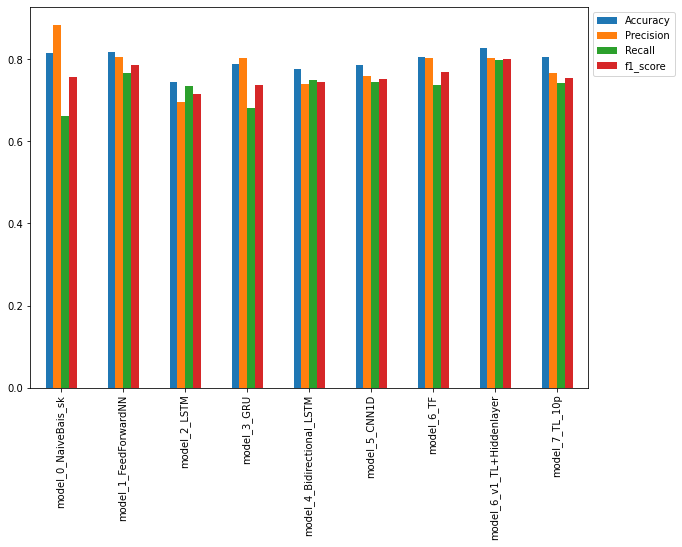

In [102]:
results_df.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1,1))

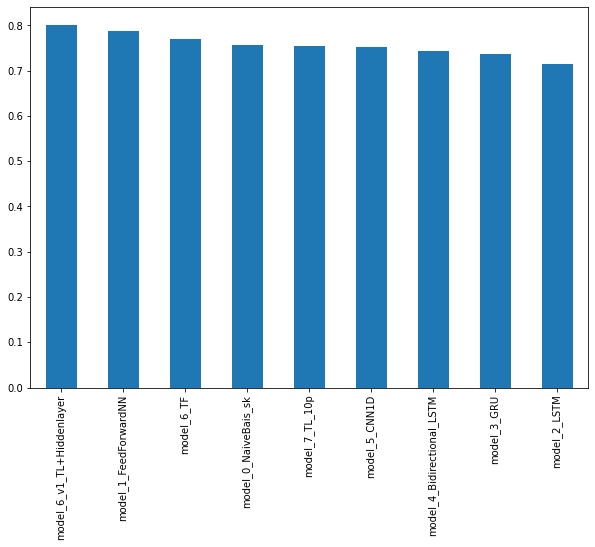

In [103]:
results_df.sort_values("f1_score", ascending=False)["f1_score"].plot(kind="bar", figsize=(10,7))

#**Tensorboard Results**: https://tensorboard.dev/experiment/Vkbr68LDSK2BLb7BjGjTvQ/

In [104]:
!tensorboard dev upload --logdir ./tensorboard/\
--name "NLP Model comparison"\
--one_shot

2023-01-08 16:49:08.477387: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Aw

#**Worst Predictions**

In [105]:
pred_probs=model_6_v1.predict(validation_text)
pred_class=tf.squeeze(pred_probs.round())

24/24 [==============================] - 1s 20ms/step


In [106]:
output_df=pd.DataFrame({"text":validation_text,
                        "true_label":validation_labels,
                        "pred_label":pred_class,
                        "pred_prob":tf.squeeze(pred_probs)})

In [107]:
output_df.head()

,text,true_label,pred_label,pred_prob
0,HTML5 Beginners Crash Course http://t.co/Y32oW...,1,0.0,0.253320
1,Has #IdentityTheft Derailed Your #TaxReturn? \...,0,0.0,0.226941
2,[Latest Post] Bayelsa poll: Tension in Bayelsa...,0,0.0,0.341619
3,Hope Dorett's 'mudslide' cake wins?? #GBBO,0,0.0,0.145721
4,1st Quality Insurance Group is #hiring License...,0,0.0,0.107088


In [108]:
wrong_df=output_df[output_df["true_label"]!=output_df["pred_label"]].sort_values("pred_prob", ascending=False)

In [109]:
wrong_df.head() #False positives

,text,true_label,pred_label,pred_prob
475,@adorableappple No reported flooding po in the...,0,1.0,0.981217
531,Tales of the #trees #deep water loving #Lake T...,0,1.0,0.935190
580,USW: 'The damage from abandoning the deal coul...,0,1.0,0.928754
77,PawSox owners public return from whirlwind tri...,0,1.0,0.914970
105,Google Alert: Emergency units simulate a chemi...,0,1.0,0.890171


In [110]:
wrong_df.tail() #False negatives

,text,true_label,pred_label,pred_prob
224,'The way you move is like a full on rainstorm ...,1,0.0,0.069242
577,Flattened thee striker,1,0.0,0.068211
190,Man Currensy really be talkin that talk... I'd...,1,0.0,0.059633
158,@lucysforsale funny cause my dumb ass was the ...,1,0.0,0.058551
194,Keep shape your shoes ??#Amazon #foot #adjust ...,1,0.0,0.050049


#**Test set**

In [111]:
test_df=pd.read_csv("test.csv")

In [112]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [113]:
test_text= test_df["text"].to_list()

In [114]:
test_text[:2]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.']

In [115]:
test_text_pred_prob=model_6_v1.predict(test_text)
test_text_pred_class=tf.squeeze(test_text_pred_prob.round())

102/102 [==============================] - 2s 21ms/step


In [116]:
test_text_pred_class[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

#**Speed-Performance trade off**

In [117]:
import time
def pred_time(model, data):
  start_time=time.perf_counter()
  y_preds=model.predict(data)
  end_time=time.perf_counter()
  total_time=end_time- start_time
  time_per_pred=total_time/len(data)
  
  return total_time, time_per_pred

In [118]:
total_time_model_6_v1,time_per_pred_model_6_v1= pred_time(model_6_v1, validation_text)

24/24 [==============================] - 1s 22ms/step


In [119]:
total_time_model_6_v1, time_per_pred_model_6_v1

(0.7047791680000159, 0.0009249070446194435)

In [120]:
total_time_model_0,time_per_pred_model_0= pred_time(model_0, validation_text)

In [121]:
total_time_model_0, time_per_pred_model_0

(0.06411408000002439, 8.41392125984572e-05)

#**Visualising speed-performance trade off**

In [122]:
import matplotlib.pyplot as plt

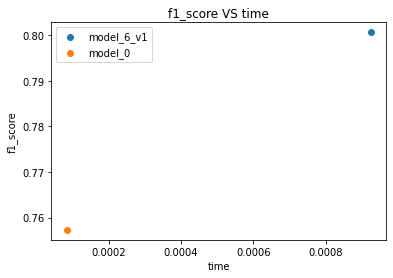

In [123]:
plt.scatter(time_per_pred_model_6_v1, model_6_v1_results["f1_score"], label="model_6_v1")
plt.scatter(time_per_pred_model_0, model_0_results["f1_score"], label="model_0")
plt.legend()
plt.title("f1_score VS time")
plt.xlabel("time")
plt.ylabel("f1_score")
plt.show()